### The goal is to estimate the proportion of DNA from two mitochondrial samples—Donor (D) and Recipient (R)—in a mixed sample (RDM), where the donor's contribution is very low (<2%). The method focuses on identifying and analyzing positions in the mitochondrial genome where the donor sample has unique homoplasmic variants compared to the recipient. By modeling the observed allele frequencies at these positions and accounting for sequencing errors, we can use Bayesian inference to estimate the donor's proportion in the mixture.



**Summary of the Steps:**

1. **Identify Informative Positions**: Select positions in the mitochondrial genome where the donor sample (D) has unique homoplasmic alleles differing from the recipient sample (R).

2. **Simulate Genomes and Sequencing Reads**:
   - Generate synthetic mitochondrial genomes for R and D.
   - Simulate sequencing reads for the mixed sample (RDM), combining R and D according to a known mixture proportion (e.g., <2%) and incorporating a sequencing error rate (e.g., 1%).

3. **Model Observed Data**:
   - At each informative position, model the number of reads supporting the D-specific allele using a binomial distribution.
   - Calculate the expected allele frequency considering both the mixture proportion and sequencing errors.

4. **Compute the Likelihood Function**:
   - For different hypothetical mixture proportions \( p \), compute the likelihood of observing the data by summing log-likelihoods across all informative positions.

5. **Perform Bayesian Inference**:
   - Use a uniform prior over \( p \) (0% to 5%).
   - Apply Bayes' theorem to obtain the posterior distribution of \( p \).
   - Derive point estimates (mean, median, mode) and 95% credible intervals from the posterior.

6. **Validate with Simulated Data**:
   - Compare estimated mixture proportions to true values used in simulations.
   - Assess accuracy, sensitivity, and robustness to sequencing errors.

7. **Analyze Performance**:
   - Visualize posterior distributions.
   - Perform sensitivity analyses by varying parameters like sequencing depth and number of informative positions to evaluate the method's effectiveness.

This streamlined approach focuses on detecting low-level mixtures by analyzing specific genomic positions and using Bayesian statistics to estimate mixture proportions accurately while accounting for sequencing errors.

In [12]:
##--------------------------------##
##--------------------------------##

**Summary of How the Method Works:**

The method aims to accurately estimate the proportion of donor mitochondrial DNA (sample D) in a mixed sample (RDM) containing predominantly recipient DNA (sample R). It focuses on specific positions in the mitochondrial genome where the donor and recipient differ—these are called **informative positions**.

1. **Identify Informative Positions**:
   - Select positions where sample D has unique homoplasmic alleles that differ from those in sample R.
   - These positions serve as markers to detect and quantify the presence of sample D in the mixture.

2. **Model Expected Allele Frequencies**:
   - For each informative position, calculate the expected frequency (\( f_i \)) of the D-specific allele in the mixed sample.
   - This calculation accounts for both the true mixture proportion (\( p \)) and the sequencing error rate (\( \epsilon \)):
     \[
     f_i = p \times (1 - \epsilon) + (1 - p) \times \epsilon
     \]
   - This formula reflects the probability of observing the D-specific allele from either true presence or sequencing errors.

3. **Collect Observed Data**:
   - Sequence the mixed sample (RDM) to obtain read data at each informative position.
   - Record the number of reads supporting the D-specific allele (\( k_i \)) and the total number of reads (\( n_i \)) at each position.

4. **Construct the Likelihood Function**:
   - For each hypothetical mixture proportion \( p \) within the expected range (e.g., 0% to 5%), compute the likelihood of observing the data.
   - Use the binomial probability mass function to model the likelihood at each position:
     \[
     L_i(p) = \binom{n_i}{k_i} f_i^{k_i} (1 - f_i)^{n_i - k_i}
     \]
   - The overall likelihood is the product of individual likelihoods across all informative positions:
     \[
     L(p) = \prod_{i} L_i(p)
     \]

5. **Perform Bayesian Inference**:
   - **Specify a Prior**:
     - Assume a uniform prior distribution for \( p \) between 0% and 5%, reflecting prior knowledge that the donor proportion is less than 2%.
   - **Compute the Posterior Distribution**:
     - Apply Bayes' theorem to update the prior belief based on the observed data:
       \[
       P(p | \text{data}) \propto L(p) \times P(p)
       \]
     - Normalize the posterior distribution so that the total probability sums to 1.
   - **Estimate the Mixture Proportion**:
     - Derive point estimates of \( p \) (mean, median, mode) from the posterior distribution.
     - Calculate credible intervals (e.g., 95% interval) to quantify uncertainty.

6. **Estimate the Donor Proportion**:
   - Use the posterior distribution to estimate the true mixture proportion of sample D in the mixed sample.
   - Provide both point estimates and credible intervals to express confidence in the estimation.

7. **Validation and Sensitivity Analysis**:
   - **Simulate Data**:
     - Create synthetic datasets with known mixture proportions and sequencing error rates to validate the method.
   - **Assess Performance**:
     - Compare estimated proportions to true values to evaluate accuracy.
     - Perform sensitivity analyses by varying key parameters (e.g., sequencing depth, error rate, number of informative positions).
     - Determine the method's robustness and the minimum detectable mixture ratio.

**In Summary**:

- The method leverages positions where the donor and recipient mitochondrial DNA differ to detect low levels of donor DNA in a mixture.
- It models the expected frequency of the donor-specific alleles in the mixed sample, accounting for sequencing errors.
- Bayesian inference is used to estimate the donor's mixture proportion, providing a probabilistic framework that incorporates prior knowledge and quantifies uncertainty.
- Validation with simulated data ensures the method is accurate and robust, capable of detecting very low mixture proportions under realistic conditions.

This approach allows for sensitive and accurate estimation of minor donor contributions in mitochondrial DNA mixtures, which is particularly useful in fields like forensic analysis, transplant monitoring, and studies of mitochondrial heteroplasmy.

In [1]:
# Bayesian Estimation of Mixture Ratios in Mitochondrial DNA Samples

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.interpolate import interp1d


## Simulation of Mitochondrial Genomes for Samples R and D
### Goal: Generate synthetic mitochondrial genomes for samples R and D, focusing on informative positions where they differ.

In [2]:
# **1. Simulation of Mitochondrial Genomes for Samples R and D**

# Parameters
L = 16569          # Length of mitochondrial genome (human mtDNA)
M = 50            # Number of informative positions (randomly selected)
mean_depth = 800   # Mean sequencing depth
epsilon = 0.02     # Sequencing error rate
alleles = ['A', 'C', 'G', 'T']
#np.random.seed(42) # For reproducibility

# Generate informative positions (randomly selected from the full genome length L)
positions = np.random.choice(np.arange(1, L+1), M, replace=False)  # Select M unique positions randomly

# Assign alleles to sample R
alleles_R = np.random.choice(alleles, M)

# Assign different alleles to sample D at the same positions
alleles_D = []
for allele_R in alleles_R:
    other_alleles = [a for a in alleles if a != allele_R]
    allele_D = np.random.choice(other_alleles)
    alleles_D.append(allele_D)
alleles_D = np.array(alleles_D)


In [3]:
# **2. Function to Simulate Sequencing Reads for Mixed Sample RDM**

def simulate_reads(p_true, M, mean_depth, epsilon):
    """
    Simulate sequencing reads for the mixed sample RDM at randomly selected informative positions.
    """
    # Simulate total reads at each informative position
    n_reads = np.random.poisson(lam=mean_depth, size=M)
    
    # Expected frequency of D-specific allele at each position
    f_i = p_true * (1 - epsilon) + (1 - p_true) * epsilon
    
    # Simulate number of reads supporting D-specific allele at each position
    k_reads = np.random.binomial(n_reads, f_i)
    
    return k_reads, n_reads, positions

In [4]:
# **3. Function to Compute Log Likelihood**

def log_likelihood(p, k_reads, n_reads, epsilon):
    """
    Compute the log likelihood of observing the data given mixture proportion p.
    """
    f_i = p * (1 - epsilon) + (1 - p) * epsilon
    f_i = np.clip(f_i, 1e-10, 1 - 1e-10)  # Avoid log(0)
    log_L_i = binom.logpmf(k_reads, n_reads, f_i)
    log_L = np.sum(log_L_i)
    return log_L

In [5]:
# **4. Function to Perform Bayesian Inference**

def bayesian_estimation(k_reads, n_reads, epsilon):
    """
    Perform Bayesian estimation of the mixture proportion p.
    """
    # Define a grid of p values
    p_grid = np.linspace(0, 0.05, 4000)
    
    # Compute log likelihood for each p
    log_L_values = np.array([log_likelihood(p, k_reads, n_reads, epsilon) for p in p_grid])
    
    # Convert log likelihoods to likelihoods
    L_values = np.exp(log_L_values - np.max(log_L_values))  # For numerical stability
    
    # Assume a uniform prior over p (from 0% to 5%)
    posterior = L_values / np.sum(L_values)
    
    # Compute estimates
    p_est_mean = np.sum(p_grid * posterior)
    cumulative_posterior = np.cumsum(posterior)
    interp_cdf = interp1d(cumulative_posterior, p_grid)
    p_est_median = interp_cdf(0.5)
    p_est_mode = p_grid[np.argmax(posterior)]
    lower_bound = interp_cdf(0.025)
    upper_bound = interp_cdf(0.975)

    #change CI values if you get error:
    #for example for 90% confidence interval:
    #lower_bound = interp_cdf(0.005)
    #upper_bound = interp_cdf(0.995)
    
    return {
        'p_grid': p_grid,
        'posterior': posterior,
        'p_est_mean': p_est_mean,
        'p_est_median': p_est_median,
        'p_est_mode': p_est_mode,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

In [6]:
# **5. Simulation and Estimation Function**

def simulate_and_estimate(p_true, M, mean_depth, epsilon):
    """
    Simulate data and estimate the mixture proportion p.
    """
    # Simulate sequencing reads
    k_reads, n_reads, positions = simulate_reads(p_true, M, mean_depth, epsilon)
    
    # Perform Bayesian estimation
    estimation_results = bayesian_estimation(k_reads, n_reads, epsilon)
    
    # Include true p in results
    estimation_results['p_true'] = p_true
    return estimation_results


In [7]:
# **6. Validation with Simulated Data**

# Test mixture proportions
p_true_values = [0.001, 0.005, 0.01, 0.02]

# Collect results
results_list = []

for p_true in p_true_values:
    results = simulate_and_estimate(p_true, M, mean_depth, epsilon)
    results_list.append(results)
    print(f"True proportion: {p_true*100:.2f}%")
    print(f"Estimated proportion (mean): {results['p_est_mean']*100:.4f}%")
    print(f"Estimated proportion (median): {results['p_est_median']*100:.4f}%")
    print(f"Estimated proportion (mode): {results['p_est_mode']*100:.4f}%")
    print(f"95% Credible Interval: [{results['lower_bound']*100:.4f}%, {results['upper_bound']*100:.4f}%]")
    print("-" * 50)

True proportion: 0.10%
Estimated proportion (mean): 0.1796%
Estimated proportion (median): 0.1773%
Estimated proportion (mode): 0.1750%
95% Credible Interval: [0.0395%, 0.3290%]
--------------------------------------------------
True proportion: 0.50%
Estimated proportion (mean): 0.5550%
Estimated proportion (median): 0.5535%
Estimated proportion (mode): 0.5526%
95% Credible Interval: [0.3957%, 0.7177%]
--------------------------------------------------
True proportion: 1.00%
Estimated proportion (mean): 1.0665%
Estimated proportion (median): 1.0650%
Estimated proportion (mode): 1.0640%
95% Credible Interval: [0.8935%, 1.2428%]
--------------------------------------------------
True proportion: 2.00%
Estimated proportion (mean): 1.8923%
Estimated proportion (median): 1.8909%
Estimated proportion (mode): 1.8905%
95% Credible Interval: [1.6991%, 2.0889%]
--------------------------------------------------


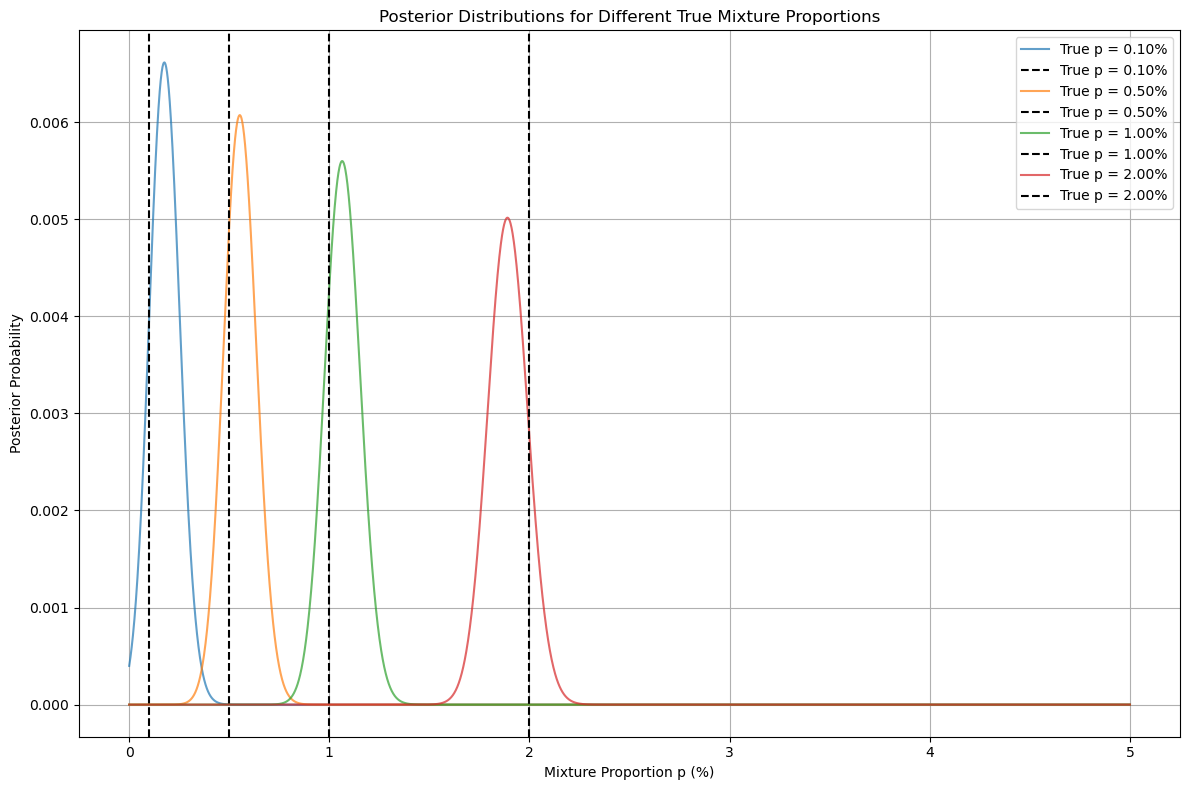

In [8]:

def plot_posterior_distribution(results_list):
    """
    Plot the posterior distributions of p for different true mixture proportions,
    with a dashed line indicating the true p-value on the x-axis.
    
    Args:
    results_list (list): A list of result dictionaries from simulate_and_estimate(),
                         where each dictionary contains the posterior distribution
                         and the true p-value ('p_true').
    """
    plt.figure(figsize=(12, 8))

    for results in results_list:
        # Plot the posterior distribution
        plt.plot(results['p_grid']*100, results['posterior'], label=f"True p = {results['p_true']*100:.2f}%", alpha=0.7)

        # Add a dashed line for the true p value on the x-axis
        plt.axvline(results['p_true']*100, color='black', linestyle='--', label=f'True p = {results["p_true"]*100:.2f}%')
    
    plt.xlabel('Mixture Proportion p (%)')
    plt.ylabel('Posterior Probability')
    plt.title('Posterior Distributions for Different True Mixture Proportions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#Assuming `results_list` is a list of results from the simulate_and_estimate function
plot_posterior_distribution(results_list)


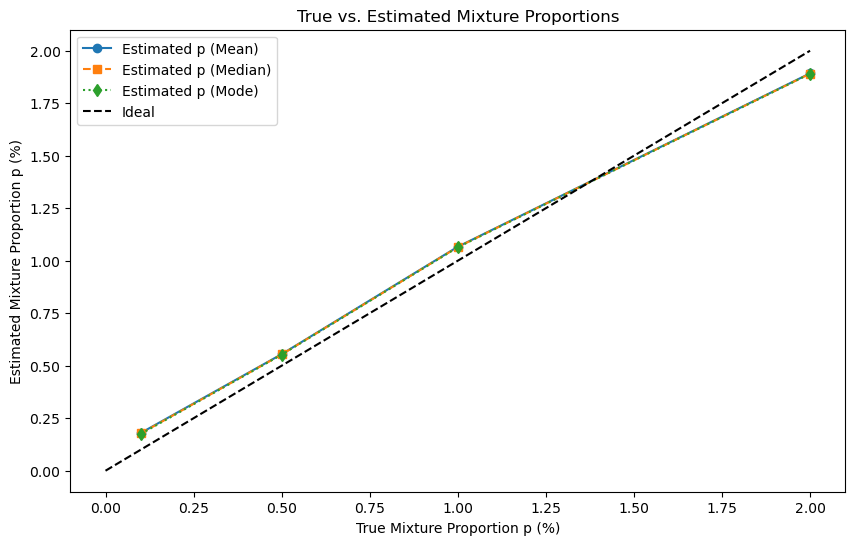

In [9]:
# **8. Performance Evaluation**

# Extract true and estimated p values
true_p_values = [res['p_true'] for res in results_list]
estimated_p_means = [res['p_est_mean'] for res in results_list]
estimated_p_medians = [res['p_est_median'] for res in results_list]
estimated_p_modes = [res['p_est_mode'] for res in results_list]

# Plot True vs. Estimated p
plt.figure(figsize=(10, 6))
plt.plot(np.array(true_p_values)*100, np.array(estimated_p_means)*100, 'o-', label='Estimated p (Mean)')
plt.plot(np.array(true_p_values)*100, np.array(estimated_p_medians)*100, 's--', label='Estimated p (Median)')
plt.plot(np.array(true_p_values)*100, np.array(estimated_p_modes)*100, 'd:', label='Estimated p (Mode)')
plt.plot([0, 2], [0, 2], 'k--', label='Ideal')
plt.xlabel('True Mixture Proportion p (%)')
plt.ylabel('Estimated Mixture Proportion p (%)')
plt.title('True vs. Estimated Mixture Proportions')
plt.legend()
plt.show()

In [10]:
# **9. Sensitivity Analysis**

# Vary sequencing depth
depth_values = [100, 200, 400, 800]
p_true = 0.005  # Fixed true p at 0.5%
results_depth = []

for depth in depth_values:
    results = simulate_and_estimate(p_true, M, depth, epsilon)
    results_depth.append(results)
    print(f"Sequencing Depth: {depth}x")
    print(f"Estimated p (mean): {results['p_est_mean']*100:.4f}%")
    print(f"95% Credible Interval: [{results['lower_bound']*100:.4f}%, {results['upper_bound']*100:.4f}%]")
    print("-" * 50)

Sequencing Depth: 100x
Estimated p (mean): 0.5193%
95% Credible Interval: [0.1081%, 0.9843%]
--------------------------------------------------
Sequencing Depth: 200x
Estimated p (mean): 0.6051%
95% Credible Interval: [0.2914%, 0.9362%]
--------------------------------------------------
Sequencing Depth: 400x
Estimated p (mean): 0.5319%
95% Credible Interval: [0.3103%, 0.7615%]
--------------------------------------------------
Sequencing Depth: 800x
Estimated p (mean): 0.4310%
95% Credible Interval: [0.2761%, 0.5893%]
--------------------------------------------------


### Preprocess the mutserve mitochondrial variant caller output tables (R, D, and RDM) 
### Extract the informative variants for use in the mixture detection model

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.interpolate import interp1d
from IPython.display import display  # For displaying DataFrames in Jupyter

def preprocess_variant_tables(recipient_file, donor_file, mixed_file, mean_depth=800,
                             donor_homoplasmy_threshold=0.95,
                             recipient_low_threshold=0.05):
    """
    Preprocess variant caller output tables for Bayesian mixture detection.

    Parameters:
    - recipient_file (str): Path to Recipient (R) variant caller output file.
    - donor_file (str): Path to Donor (D) variant caller output file.
    - mixed_file (str): Path to Mixed Sample (RDM) variant caller output file.
    - mean_depth (int): Assumed mean sequencing depth for RDM sample. Default is 800.
    - donor_homoplasmy_threshold (float): Threshold to consider donor variant as homoplasmic. Default is 0.95.
    - recipient_low_threshold (float): Threshold below which recipient variant is considered low or absent. Default is 0.05.

    Returns:
    - informative_df (DataFrame): DataFrame containing informative positions with k_reads and n_reads.
    - common_variants_df (DataFrame): DataFrame containing common variants between Donor and Recipient.
    """

    # Load the tables
    try:
        df_R = pd.read_csv(recipient_file, sep='\t')
        print("=== Recipient (R) Variants Loaded Successfully ===")
        display(df_R.head())  # Display first 5 rows of Recipient variants
    except Exception as e:
        print(f"Error loading Recipient (R) file: {e}")
        return None, None

    try:
        df_D = pd.read_csv(donor_file, sep='\t')
        print("=== Donor (D) Variants Loaded Successfully ===")
        display(df_D.head())  # Display first 5 rows of Donor variants
    except Exception as e:
        print(f"Error loading Donor (D) file: {e}")
        return None, None

    try:
        df_RDM = pd.read_csv(mixed_file, sep='\t')
        print("=== Mixed Sample (RDM) Variants Loaded Successfully ===")
        display(df_RDM.head())  # Display first 5 rows of Mixed samples
    except Exception as e:
        print(f"Error loading Mixed Sample (RDM) file: {e}")
        return None, None

    # Ensure required columns are present
    required_cols = {'Pos', 'Ref', 'Variant', 'VariantLevel'}
    for df, name in zip([df_R, df_D, df_RDM], ['Recipient (R)', 'Donor (D)', 'Mixed (RDM)']):
        if not required_cols.issubset(df.columns):
            print(f"Error: {name} table is missing required columns. Required columns are: {required_cols}")
            return None, None

    # **Data Type Conversion for VariantLevel Columns**
    # Convert 'VariantLevel' columns to numeric, coercing errors to NaN
    for df, name in zip([df_R, df_D, df_RDM], ['Recipient (R)', 'Donor (D)', 'Mixed (RDM)']):
        df['VariantLevel'] = pd.to_numeric(df['VariantLevel'], errors='coerce')
        non_numeric = df['VariantLevel'].isna().sum()
        if non_numeric > 0:
            print(f"Warning: {non_numeric} non-numeric entries found in {name}'s 'VariantLevel' column. These will be set to 0.")
            df['VariantLevel'] = df['VariantLevel'].fillna(0.0)
    
    # **Identify Common Variants Between Donor and Recipient**
    # Common variants are positions where both D and R have variants
    common_variants_df = pd.merge(df_D, df_R, on='Pos', suffixes=('_D', '_R'), how='inner')

    print(f"\n=== Common Variants Between Donor (D) and Recipient (R) ===")
    print(f"Number of common variant positions: {len(common_variants_df)}")
    display(common_variants_df.head())  # Display first 5 common variants

    # Analyze how many of these common variants have the same or different alleles
    common_variants_df['Same_Variant'] = common_variants_df['Variant_D'] == common_variants_df['Variant_R']
    same_variant_count = common_variants_df['Same_Variant'].sum()
    different_variant_count = len(common_variants_df) - same_variant_count

    print(f"Number of common variants with the same allele: {same_variant_count} ({(same_variant_count / len(common_variants_df) * 100) if len(common_variants_df) > 0 else 0:.2f}%)")
    print(f"Number of common variants with different alleles: {different_variant_count} ({(different_variant_count / len(common_variants_df) * 100) if len(common_variants_df) > 0 else 0:.2f}%)")

    # **Identify Informative Positions**
    # Criteria:
    # - Donor has homoplasmic variant (VariantLevel >= donor_homoplasmy_threshold)
    # - Recipient has low or no variant (VariantLevel < recipient_low_threshold)

    # Filter donor for homoplasmic variants
    df_D_homoplasmic = df_D[df_D['VariantLevel'] >= donor_homoplasmy_threshold]
    print(f"\nNumber of homoplasmic variants in Donor (D): {len(df_D_homoplasmic)}")
    display(df_D_homoplasmic.head())  # Display first 5 homoplasmic Donor variants

    # Merge with recipient to check their variant levels at the same positions
    merged_df = pd.merge(df_D_homoplasmic, df_R, on='Pos', suffixes=('_D', '_R'), how='left')

    # Handle positions where Recipient does not have the variant (NaN)
    merged_df['VariantLevel_R'] = merged_df['VariantLevel_R'].fillna(0.0)

    # Apply recipient low threshold
    informative_positions = merged_df[merged_df['VariantLevel_R'] < recipient_low_threshold]['Pos'].unique()

    print(f"\nIdentified {len(informative_positions)} informative positions where Donor has homoplasmic variants and Recipient has low or no variant.")

    # **Extract VariantLevel from Mixed Sample (RDM) for Informative Positions**
    df_RDM_informative = df_RDM[df_RDM['Pos'].isin(informative_positions)]

    # Handle missing positions by assuming VariantLevel = 0 (no variant detected)
    missing_positions = set(informative_positions) - set(df_RDM_informative['Pos'])
    if missing_positions:
        print(f"{len(missing_positions)} informative positions not found in RDM. Assuming VariantLevel = 0.")
        df_missing = pd.DataFrame({
            'Pos': list(missing_positions),
            'Ref': ['N']*len(missing_positions),  # 'N' denotes any nucleotide
            'Variant': ['N']*len(missing_positions),
            'VariantLevel': [0.0]*len(missing_positions)
        })
        df_RDM_informative = pd.concat([df_RDM_informative, df_missing], ignore_index=True)

    # **Display RDM Informative Positions**
    print("\n=== Informative Positions in Mixed Sample (RDM) ===")
    display(df_RDM_informative.head())

    # **Calculate k_reads and n_reads**
    # Assuming VariantLevel = VAF = k_reads / n_reads
    # Thus, k_reads = VAF * n_reads
    # Since n_reads is not provided, we'll use the mean_depth
    df_RDM_informative['n_reads'] = mean_depth
    df_RDM_informative['k_reads'] = (df_RDM_informative['VariantLevel'] * df_RDM_informative['n_reads']).round().astype(int)

    # **Select Relevant Columns**
    informative_df = df_RDM_informative[['Pos', 'k_reads', 'n_reads']].copy()

    # Reset index
    informative_df.reset_index(drop=True, inplace=True)

    return informative_df, common_variants_df

# **Example Usage of the Enhanced Preprocessing Function**

In [16]:
# **Example Usage of the Preprocessing Function**

# Define paths to your variant caller output files
recipient_file = '/Users/hhakimjavadi/UFL Dropbox/Hesamedin Hakimjavadi/mixture_dna/workflow/mutserv/out/samples_variant_call_results/DA01_Batch1.txt'   # Replace with your actual Recipient (R) file path
donor_file =     '/Users/hhakimjavadi/UFL Dropbox/Hesamedin Hakimjavadi/mixture_dna/workflow/mutserv/out/samples_variant_call_results/DA02_Batch2.txt'       # Replace with your actual Donor (D) file path
mixed_file =     '/Users/hhakimjavadi/UFL Dropbox/Hesamedin Hakimjavadi/mixture_dna/workflow/mutserv/out/samples_variant_call_results/RD_mix_0.01_2k.txt'     # Replace with your actual Mixed (RDM) file path

# Preprocess the variant tables to obtain informative positions
informative_positions_df = preprocess_variant_tables(recipient_file, donor_file, mixed_file,
                                                      mean_depth=800,
                                                      donor_homoplasmy_threshold=0.99,
                                                      recipient_low_threshold=0.01)


=== Recipient (R) Variants Loaded Successfully ===


,ID,Filter,Pos,Ref,Variant,VariantLevel,MeanBaseQuality,Coverage,GT,Type,...,NuMTs_dayama,Helix_count_hom,Helix_count_het,Helix_vaf_hom,Helix_vaf_het,Helix_haplogroups,rCRS_Surr_seq,LowComplexityRegion,DuplSeq_rCRS,DuplSeq_rCRS_pos
0,CPM00029354-PL-D-AI2kAP_20240529-dragen.bam,PASS,73,A,G,1,39.74,990,1,1,...,1.0,119934.0,60.0,0.611961,0.000306,"U:24492,T:16962,J:15973,K:14791,A:6089,H:5724,...",GGGGT[A/G]TGCAC,0.0,NaN,NaN
1,CPM00029354-PL-D-AI2kAP_20240529-dragen.bam,PASS,152,T,C,0.998,39.71,1212,1,1,...,1.0,43990.0,1503.0,0.224458,0.007669,"H:10316,U:6126,K:5566,T:5328,J:3365,L2:2381,I:...",CATCC[T/C]ATTAT,0.0,NaN,NaN
2,CPM00029354-PL-D-AI2kAP_20240529-dragen.bam,PASS,185,G,A,0.996,39.81,1181,1,1,...,NaN,10568.0,317.0,0.053923,0.001617,"J:8782,U:729,L0:279,H:236,L3:112,A:73,W:52,N:5...",TACAG[G/A]CGAAC,0.0,NaN,NaN
3,CPM00029354-PL-D-AI2kAP_20240529-dragen.bam,PASS,228,G,A,0.996,39.48,1147,1,1,...,NaN,9673.0,191.0,0.049356,0.000975,"J:8503,U:445,H:275,B:128,HV:108,L1:60,L2:37,R:...",TTGTA[G/A]GACAT,0.0,NaN,NaN
4,CPM00029354-PL-D-AI2kAP_20240529-dragen.bam,PASS,263,A,G,0.999,39.49,1151,1,1,...,NaN,193861.0,11.0,0.989173,0.000056,"H:69957,U:24424,T:16915,J:15981,K:14811,A:6179...",CAGCC[A/G]CTTTC,0.0,NaN,NaN


=== Donor (D) Variants Loaded Successfully ===


,ID,Filter,Pos,Ref,Variant,VariantLevel,MeanBaseQuality,Coverage,GT,Type,...,NuMTs_dayama,Helix_count_hom,Helix_count_het,Helix_vaf_hom,Helix_vaf_het,Helix_haplogroups,rCRS_Surr_seq,LowComplexityRegion,DuplSeq_rCRS,DuplSeq_rCRS_pos
0,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,152,T,C,0.998,39.66,49048,1,1,...,1.0,43990.0,1503.0,0.224458,0.007669,"H:10316,U:6126,K:5566,T:5328,J:3365,L2:2381,I:...",CATCC[T/C]ATTAT,0,NaN,NaN
1,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,263,A,G,0.999,39.39,48988,1,1,...,NaN,193861.0,11.0,0.989173,0.000056,"H:69957,U:24424,T:16915,J:15981,K:14811,A:6179...",CAGCC[A/G]CTTTC,0,NaN,NaN
2,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,310,T,C,0.067,37.10,35830,0/1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,CCCCC[T/C]CCCCC,1,NaN,NaN
3,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,750,A,G,0.999,39.66,58819,1,1,...,0.0,192986.0,13.0,0.984708,0.000066,"H:68880,U:24516,T:16961,J:15995,K:14812,A:6232...",AAAGG[A/G]ACAAG,0,NaN,NaN
4,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,1438,A,G,0.999,39.76,61893,1,1,...,8.0,189889.0,18.0,0.968905,0.000092,"H:66674,U:24479,T:16955,J:15974,K:14805,A:6216...",AAACT[A/G]AGAGT,0,NaN,NaN


=== Mixed Sample (RDM) Variants Loaded Successfully ===


,ID,Filter,Pos,Ref,Variant,VariantLevel,MeanBaseQuality,Coverage,GT,Type,...,NuMTs_dayama,Helix_count_hom,Helix_count_het,Helix_vaf_hom,Helix_vaf_het,Helix_haplogroups,rCRS_Surr_seq,LowComplexityRegion,DuplSeq_rCRS,DuplSeq_rCRS_pos
0,1pct-2k-AB.sorted.bam,PASS,73,A,G,0.997,35.19,100117,1,1,...,1.0,119934.0,60.0,0.611961,0.000306,"U:24492,T:16962,J:15973,K:14791,A:6089,H:5724,...",GGGGT[A/G]TGCAC,0,NaN,NaN
1,1pct-2k-AB.sorted.bam,PASS,152,T,C,0.994,34.92,100601,1,1,...,1.0,43990.0,1503.0,0.224458,0.007669,"H:10316,U:6126,K:5566,T:5328,J:3365,L2:2381,I:...",CATCC[T/C]ATTAT,0,NaN,NaN
2,1pct-2k-AB.sorted.bam,PASS,185,G,A,0.993,34.90,98739,1,1,...,NaN,10568.0,317.0,0.053923,0.001617,"J:8782,U:729,L0:279,H:236,L3:112,A:73,W:52,N:5...",TACAG[G/A]CGAAC,0,NaN,NaN
3,1pct-2k-AB.sorted.bam,PASS,228,G,A,0.995,35.28,93137,1,1,...,NaN,9673.0,191.0,0.049356,0.000975,"J:8503,U:445,H:275,B:128,HV:108,L1:60,L2:37,R:...",TTGTA[G/A]GACAT,0,NaN,NaN
4,1pct-2k-AB.sorted.bam,PASS,263,A,G,0.996,34.55,72825,1,1,...,NaN,193861.0,11.0,0.989173,0.000056,"H:69957,U:24424,T:16915,J:15981,K:14811,A:6179...",CAGCC[A/G]CTTTC,0,NaN,NaN



=== Common Variants Between Donor (D) and Recipient (R) ===
Number of common variant positions: 8


,ID_D,Filter_D,Pos,Ref_D,Variant_D,VariantLevel_D,MeanBaseQuality_D,Coverage_D,GT_D,Type_D,...,NuMTs_dayama_R,Helix_count_hom_R,Helix_count_het_R,Helix_vaf_hom_R,Helix_vaf_het_R,Helix_haplogroups_R,rCRS_Surr_seq_R,LowComplexityRegion_R,DuplSeq_rCRS_R,DuplSeq_rCRS_pos_R
0,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,152,T,C,0.998,39.66,49048,1,1,...,1.0,43990.0,1503.0,0.224458,0.007669,"H:10316,U:6126,K:5566,T:5328,J:3365,L2:2381,I:...",CATCC[T/C]ATTAT,0.0,NaN,NaN
1,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,263,A,G,0.999,39.39,48988,1,1,...,NaN,193861.0,11.0,0.989173,0.000056,"H:69957,U:24424,T:16915,J:15981,K:14811,A:6179...",CAGCC[A/G]CTTTC,0.0,NaN,NaN
2,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,310,T,C,0.067,37.10,35830,0/1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,CCCCC[T/C]CCCCC,1.0,NaN,NaN
3,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,750,A,G,0.999,39.66,58819,1,1,...,0.0,192986.0,13.0,0.984708,0.000066,"H:68880,U:24516,T:16961,J:15995,K:14812,A:6232...",AAAGG[A/G]ACAAG,0.0,NaN,NaN
4,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,1438,A,G,0.999,39.76,61893,1,1,...,8.0,189889.0,18.0,0.968905,0.000092,"H:66674,U:24479,T:16955,J:15974,K:14805,A:6216...",AAACT[A/G]AGAGT,0.0,NaN,NaN


Number of common variants with the same allele: 8 (100.00%)
Number of common variants with different alleles: 0 (0.00%)

Number of homoplasmic variants in Donor (D): 13


,ID,Filter,Pos,Ref,Variant,VariantLevel,MeanBaseQuality,Coverage,GT,Type,...,NuMTs_dayama,Helix_count_hom,Helix_count_het,Helix_vaf_hom,Helix_vaf_het,Helix_haplogroups,rCRS_Surr_seq,LowComplexityRegion,DuplSeq_rCRS,DuplSeq_rCRS_pos
0,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,152,T,C,0.998,39.66,49048,1,1,...,1.0,43990.0,1503.0,0.224458,0.007669,"H:10316,U:6126,K:5566,T:5328,J:3365,L2:2381,I:...",CATCC[T/C]ATTAT,0,NaN,NaN
1,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,263,A,G,0.999,39.39,48988,1,1,...,NaN,193861.0,11.0,0.989173,0.000056,"H:69957,U:24424,T:16915,J:15981,K:14811,A:6179...",CAGCC[A/G]CTTTC,0,NaN,NaN
3,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,750,A,G,0.999,39.66,58819,1,1,...,0.0,192986.0,13.0,0.984708,0.000066,"H:68880,U:24516,T:16961,J:15995,K:14812,A:6232...",AAAGG[A/G]ACAAG,0,NaN,NaN
4,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,1438,A,G,0.999,39.76,61893,1,1,...,8.0,189889.0,18.0,0.968905,0.000092,"H:66674,U:24479,T:16955,J:15974,K:14805,A:6216...",AAACT[A/G]AGAGT,0,NaN,NaN
5,CPM00029862-PL-D-DA02-2k-AP_20240722-dragen.bam,PASS,3745,G,A,0.999,39.51,60213,1,1,...,2.0,252.0,25.0,0.001286,0.000128,"H:127,U:24,L2:22,HV:19,C:13,B:12,K:8,A:7,J:4,T...",CCCTA[G/A]CCATC,0,NaN,NaN



Identified 6 informative positions where Donor has homoplasmic variants and Recipient has low or no variant.
6 informative positions not found in RDM. Assuming VariantLevel = 0.

=== Informative Positions in Mixed Sample (RDM) ===


,ID,Filter,Pos,Ref,Variant,VariantLevel,MeanBaseQuality,Coverage,GT,Type,...,NuMTs_dayama,Helix_count_hom,Helix_count_het,Helix_vaf_hom,Helix_vaf_het,Helix_haplogroups,rCRS_Surr_seq,LowComplexityRegion,DuplSeq_rCRS,DuplSeq_rCRS_pos
0,NaN,NaN,3745,N,N,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,16291,N,N,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,8277,N,N,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,16519,N,N,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,16093,N,N,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:

if informative_positions_df is not None and common_variants_df is not None:
    print("\n=== Preprocessed Informative Positions ===")
    display(informative_positions_df.head())

    # Save the preprocessed data to a CSV file for future use
    informative_positions_df.to_csv('informative_positions_RDM.csv', index=False)
    print("\nInformative positions saved to 'informative_positions_RDM.csv'.")

    # **Integrate with Bayesian Estimation**

    # Define the Bayesian Estimation function (ensure this is defined before usage)
    def bayesian_estimation(k_reads, n_reads, epsilon):
        """
        Perform Bayesian estimation of the mixture proportion p.
        """
        # Define a grid of p values
        p_grid = np.linspace(0, 0.05, 4000)
        
        # Compute log likelihood for each p
        log_L_values = np.array([log_likelihood(p, k_reads, n_reads, epsilon) for p in p_grid])
        
        # Convert log likelihoods to likelihoods
        L_values = np.exp(log_L_values - np.max(log_L_values))  # For numerical stability
        
        # Assume a uniform prior over p (from 0% to 5%)
        posterior = L_values / np.sum(L_values)
        
        # Compute estimates
        p_est_mean = np.sum(p_grid * posterior)
        cumulative_posterior = np.cumsum(posterior)
        interp_cdf = interp1d(cumulative_posterior, p_grid, bounds_error=False, fill_value=(p_grid[0], p_grid[-1]))
        p_est_median = interp_cdf(0.5)
        p_est_mode = p_grid[np.argmax(posterior)]
        lower_bound = interp_cdf(0.025)
        upper_bound = interp_cdf(0.975)
        
        return {
            'p_grid': p_grid,
            'posterior': posterior,
            'p_est_mean': p_est_mean,
            'p_est_median': p_est_median,
            'p_est_mode': p_est_mode,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

    # **Compute Log Likelihood Function (Required by bayesian_estimation)**

    def log_likelihood(p, k_reads, n_reads, epsilon):
        """
        Compute the log likelihood of observing the data given mixture proportion p.
        """
        f_i = p * (1 - epsilon) + (1 - p) * epsilon
        f_i = np.clip(f_i, 1e-10, 1 - 1e-10)  # Avoid log(0)
        log_L_i = binom.logpmf(k_reads, n_reads, f_i)
        log_L = np.sum(log_L_i)
        return log_L

    # **Extract k_reads and n_reads for Bayesian estimation**
    k_reads_real = informative_positions_df['k_reads'].values
    n_reads_real = informative_positions_df['n_reads'].values

    # Assume a known sequencing error rate (adjust if different)
    epsilon = 0.02

    # Perform Bayesian estimation using the preprocessed real data
    estimation_results_real = bayesian_estimation(k_reads_real, n_reads_real, epsilon)

    # **Display Estimation Results**
    print("\n=== Bayesian Estimation Results for Real Data ===")
    print(f"Estimated proportion (mean): {estimation_results_real['p_est_mean']*100:.4f}%")
    print(f"Estimated proportion (median): {estimation_results_real['p_est_median']*100:.4f}%")
    print(f"Estimated proportion (mode): {estimation_results_real['p_est_mode']*100:.4f}%")
    print(f"95% Credible Interval: [{estimation_results_real['lower_bound']*100:.4f}%, {estimation_results_real['upper_bound']*100:.4f}%]")

    # **Plot Posterior Distribution for Real Data**

    # Create a DataFrame for plotting
    posterior_df_real = pd.DataFrame({
        'p_grid': estimation_results_real['p_grid'] * 100,       # Convert to percentage
        'posterior': estimation_results_real['posterior']
    })

    plt.figure(figsize=(10, 6))
    plt.plot(posterior_df_real['p_grid'], posterior_df_real['posterior'], label='Posterior Distribution')
    plt.axvline(estimation_results_real['p_est_mean']*100, color='red', linestyle='--', label='Estimated Mean')
    plt.xlabel('Mixture Proportion p (%)')
    plt.ylabel('Posterior Probability')
    plt.title('Posterior Distribution of Mixture Proportion (Real Data)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # **Display Common Variants Summary**
    print("\n=== Summary of Common Variants Between Donor and Recipient ===")
    print(f"Total common variant positions: {len(common_variants_df)}")
    same_variant_percentage = (same_variant_count / len(common_variants_df) * 100) if len(common_variants_df) > 0 else 0
    different_variant_percentage = (different_variant_count / len(common_variants_df) * 100) if len(common_variants_df) > 0 else 0
    print(f"Variants with the same allele: {same_variant_count} ({same_variant_percentage:.2f}%)")
    print(f"Variants with different alleles: {different_variant_count} ({different_variant_percentage:.2f}%)")

NameError: name 'common_variants_df' is not defined